In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Road Detection" "/content/Dataset"

Mounted at /gdrive


In [3]:
import os
import numpy as np
import pandas as pd
import keras
from keras.models import load_model
from keras.metrics import MeanIoU
import imageio
from PIL import Image
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
# import segmentation_models as sm
%matplotlib inline

In [4]:
path = '/content/Dataset/'
image_path = os.path.join(path, 'OriginalFrames/')
mask_path = os.path.join(path, 'ColoredMasks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [5]:
image_list = sorted(image_list)
mask_list = sorted(mask_list)

In [6]:
images = []
for i in range(len(image_list)):
    img = Image.open(image_list[i])
    img = img.resize((256, 256))
    img = asarray(img)
    images.append(img)

In [7]:
masks = []
for i in range(len(mask_list)):
    mask = Image.open(mask_list[i])
    mask = mask.resize((256, 256))
    mask = asarray(mask)
    masks.append(mask)

In [8]:
images = np.array(images)
masks = np.array(masks)

(701, 256, 256, 3)


Text(0.5, 1.0, 'Segmentation')

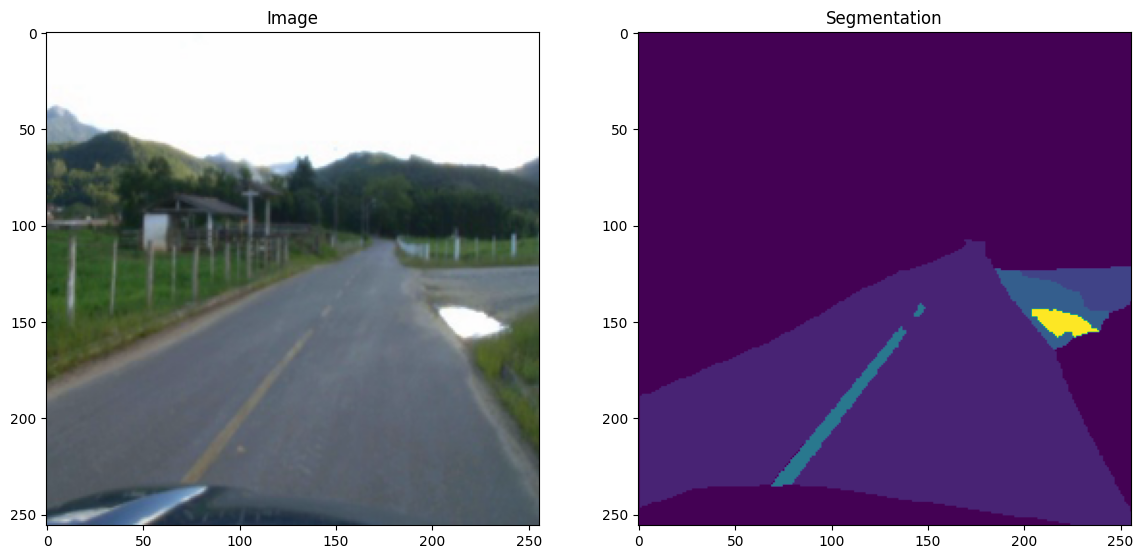

In [9]:
image = images[0]
mask = masks[0]
print(images.shape)
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [10]:
def custom_loss_func():
  focal_loss = sm.losses.CategoricalFocalLoss()
  return focal_loss

In [11]:
def iou_score():
  iou = sm.metrics.IOUScore(threshold=0.5)
  return iou

In [12]:
def fscore():
  fscore = sm.metrics.FScore(threshold=0.5)
  return fscore

In [13]:
model = load_model("/content/Dataset/resnetUnet.hdf5", custom_objects={'focal_loss': custom_loss_func, 'iou_score': iou_score, 'f1-score': fscore})

In [14]:
def get_prediction(img):
  img = img.reshape(1, 256, 256, 3)
  y_pred = model.predict(img)
  y_pred = np.argmax(y_pred, axis=3)
  y_pred = y_pred.reshape(256, 256)
  return y_pred

In [15]:
pred = get_prediction(images[0])

1/1 [==============================] - 1s 1s/step


In [16]:
def add_color(img):
  img = img.reshape(256, 256, 1)
  frame = np.concatenate((img, img, img), axis=2)
  width = frame.shape[0]
  height = frame.shape[1]
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127)
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255)
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127)
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255)
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127)
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
  return frame

In [17]:
img = add_color(pred)

In [18]:
actual = add_color(masks[0])

In [19]:
img = img.astype('uint8')

Text(0.5, 1.0, 'Masked')

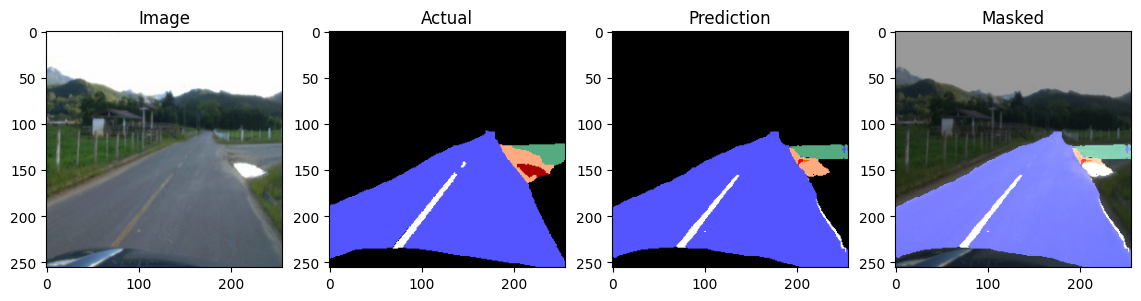

In [54]:
fig, arr = plt.subplots(1, 4, figsize=(14, 10))
arr[0].imshow(images[0])
arr[0].set_title('Image')
arr[1].imshow(actual)
arr[1].set_title('Actual')
arr[2].imshow(img)
arr[2].set_title('Prediction')
arr[3].imshow(cv2.addWeighted(images[0], 0.6, img, 0.8, 1))
arr[3].set_title('Masked')

In [ ]:
video = cv2.VideoCapture('yt5s.com-Road surface detection and differentiation considering surface damages on RTK dataset (online-video-cutter.com).mp4')

In [ ]:
output_video = 'output_video.mp4'
frame_width, frame_height = (256, 256)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_video, fourcc, 30.0, (frame_width, frame_height))

In [ ]:
success = True

while success:
    success, image = video.read()

    if success:
        # print(image.shape)
        image = cv2.resize(image, (256, 256))
        image = image.astype(np.uint8)
        # cv2.imshow('Frame', image)
        pred = get_prediction(image)
        img = add_color(pred)
        img = img.astype('uint8')
        # cv2.imshow("Result", img)
        video_writer.write(img)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

In [ ]:
video.release()
cv2.destroyAllWindows()